In [8]:
import cv2
import numpy as np
import os
import matplotlib

TASK-1

In [ ]:


video_path =r"C:\Users\saich\Downloads\Video_Task_4.mp4"
cap = cv2.VideoCapture(video_path)

back_sub = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=True)

person_id = None
person_color = (0, 255, 0)  # Bounding box color
font = cv2.FONT_HERSHEY_SIMPLEX

def get_centroid(x, y, w, h):
    return (int(x + w / 2), int(y + h / 2))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break


    fg_mask = back_sub.apply(frame)
    

    _, fg_mask = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)
    

    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:

        if cv2.contourArea(cnt) < 1000:
            continue

        x, y, w, h = cv2.boundingRect(cnt)
        
        # Assume largest contour area belongs to person
        centroid = get_centroid(x, y, w, h)


        cv2.rectangle(frame, (x, y), (x + w, y + h), person_color, 2)
        cv2.putText(frame, "Person", (x, y - 10), font, 0.6, person_color, 2)

    # Display the frame with the bounding box
    cv2.imshow("Tracking", frame)

    # Exit if 'q' is pressed
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

TASK-2

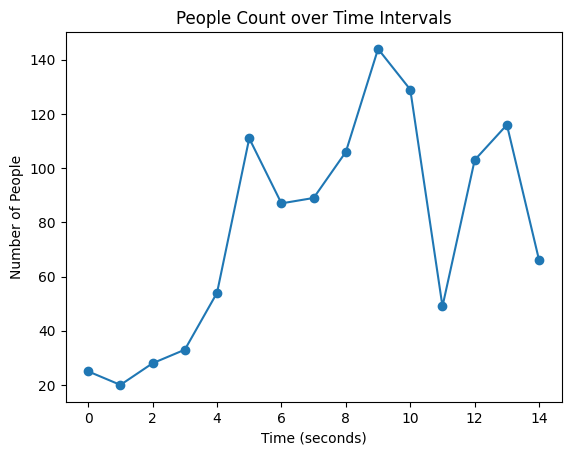

Peak shopping duration: 9-10 seconds with 144 people
Peak shopping duration frame saved at: C:\Users\saich\Downloads\Peak_Shopping_Duration_Frame.jpg


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def count_people_in_frame(prev_frame, curr_frame, min_contour_area=500):
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    prev_blur = cv2.GaussianBlur(prev_gray, (21, 21), 0)
    curr_blur = cv2.GaussianBlur(curr_gray, (21, 21), 0)
    diff = cv2.absdiff(prev_blur, curr_blur)
    _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)
    thresh = cv2.dilate(thresh, None, iterations=2)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    people_count = sum(1 for c in contours if cv2.contourArea(c) > min_contour_area)
    return people_count

# Load video
video_path = r"C:\Users\saich\Downloads\Task_2_video.mp4"
cap = cv2.VideoCapture(video_path)


if not cap.isOpened():
    print("Error: Could not open video.")
    exit()


fps = cap.get(cv2.CAP_PROP_FPS)
interval_frames = int(fps)  # 1-second intervals
frame_count = 0
people_counts = []
interval_people_count = 0
frames_to_save = []  # Store frames corresponding to each interval

# Process frames
ret, prev_frame = cap.read()
while cap.isOpened() and ret:
    ret, curr_frame = cap.read()
    if not ret:
        break

  
    people_count = count_people_in_frame(prev_frame, curr_frame)
    interval_people_count += people_count

    # Update for the next frame
    frame_count += 1
    prev_frame = curr_frame

    # Check if we've reached the interval
    if frame_count % interval_frames == 0:
        people_counts.append(interval_people_count)
        frames_to_save.append(curr_frame.copy())  # Save the frame for this interval
        interval_people_count = 0

cap.release()

# Plotting people counts over intervals
time_intervals = [i for i in range(len(people_counts))]  # 1-second intervals
plt.plot(time_intervals, people_counts, marker='o')
plt.xlabel("Time (seconds)")
plt.ylabel("Number of People")
plt.title("People Count over Time Intervals")
plt.show()


if people_counts:
    peak_interval_idx = np.argmax(people_counts)
    peak_count = people_counts[peak_interval_idx]
    peak_time = time_intervals[peak_interval_idx]
    print(f"Peak shopping duration: {peak_time}-{peak_time + 1} seconds with {peak_count} people")

    # Save the frame corresponding to the peak interval
    save_path = r"C:\Users\saich\Downloads\Peak_Shopping_Duration_Frame.jpg"
    cv2.imwrite(save_path, frames_to_save[peak_interval_idx])
    print(f"Peak shopping duration frame saved at: {save_path}")
else:
    print("No people detected in the video.")


TASK-3

In [ ]:
# Set paths for reference image and video
reference_image_path = r"C:\Users\saich\Pictures\Screenshots\Screenshot 2024-11-14 112640.png"
video_path = r"C:\Users\saich\Downloads\task_3_video.mp4"


output_folder = r"C:\Users\saich\Downloads\output frames"
os.makedirs(output_folder, exist_ok=True)

# Load the reference image and convert it to grayscale
reference_image = cv2.imread(reference_image_path)
reference_gray = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

ref_faces = face_cascade.detectMultiScale(reference_gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Ensure there's at least one face detected in the reference image
if len(ref_faces) == 0:
    print("No faces found in the reference image.")
    exit()
else:
    print(f"{len(ref_faces)} face(s) detected in the reference image.")


x, y, w, h = max(ref_faces, key=lambda face: face[2] * face[3])
reference_face = reference_gray[y:y+h, x:x+w]

# Load the video
cap = cv2.VideoCapture(video_path)

# Initialize a frame counter
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the current frame
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    match_found = False  # Flag to check if any match is found in the current frame

 
    for (fx, fy, fw, fh) in faces:
        # Extract the face from the frame
        face_in_frame = gray_frame[fy:fy+fh, fx:fx+fw]

        # Resize the reference face and detected face to the same size for comparison
        resized_reference = cv2.resize(reference_face, (fw, fh))
        match_result = cv2.matchTemplate(face_in_frame, resized_reference, cv2.TM_CCOEFF_NORMED)
        _, match_val, _, _ = cv2.minMaxLoc(match_result)


        match_threshold = 0.7
        if match_val > match_threshold:

            cv2.rectangle(frame, (fx, fy), (fx + fw, fy + fh), (0, 255, 0), 2)
            cv2.putText(frame, f'Match: {match_val:.2f}', (fx, fy - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            print(f"Match found in frame {frame_count} with similarity score: {match_val:.2f}")

            # Save the frame with match to the output folder
            output_frame_path = os.path.join(output_folder, f'frame_{frame_count}.jpg')
            cv2.imwrite(output_frame_path, frame)
            match_found = True


    if match_found:
        cv2.imshow('Matching Frame', frame)

    # Break on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release video capture and close windows
cap.release()
cv2.destroyAllWindows()


2 face(s) detected in the reference image.
Match found in frame 167 with similarity score: 0.84
Match found in frame 168 with similarity score: 0.85
Match found in frame 169 with similarity score: 0.83
Match found in frame 170 with similarity score: 0.85
Match found in frame 171 with similarity score: 0.80
Match found in frame 172 with similarity score: 0.73
Match found in frame 173 with similarity score: 0.74
Match found in frame 174 with similarity score: 0.72
Match found in frame 176 with similarity score: 0.73
Match found in frame 177 with similarity score: 0.72
Match found in frame 178 with similarity score: 0.76
Match found in frame 179 with similarity score: 0.74
Match found in frame 180 with similarity score: 0.74
Match found in frame 181 with similarity score: 0.73
Match found in frame 182 with similarity score: 0.75
Match found in frame 183 with similarity score: 0.71
Match found in frame 184 with similarity score: 0.75
Match found in frame 185 with similarity score: 0.74
Mat

TASK-4

In [ ]:
# Load the video
video_path = r"C:\Users\saich\Downloads\Video_Task_4.mp4"  
cap = cv2.VideoCapture(video_path)


roi_x, roi_y, roi_width, roi_height = 100, 200, 200, 150  # Adjust based on entrance position

# Background subtraction for motion detection
fgbg = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50)

# Initialize counters for people entering and exiting
enter_count = 0
exit_count = 0


last_direction = None
direction_threshold = 30  # Minimum movement threshold for counting

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Define the ROI for detecting motion at the entrance
    roi = frame[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width]
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    blurred_roi = cv2.GaussianBlur(gray_roi, (5, 5), 0)

    # Detect motion using background subtraction
    fg_mask = fgbg.apply(blurred_roi)
    _, fg_mask = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)

    # Find contours to identify moving objects
    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Ignore small contours to avoid noise
        if cv2.contourArea(contour) < 500:
            continue

        # Draw bounding box around detected motion in the ROI
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(roi, (x, y), (x+w, y+h), (0, 255, 0), 2)


        if last_direction is None:
            last_direction = y
        else:
            direction = y - last_direction
            if abs(direction) > direction_threshold:
                if direction < 0:
                    enter_count += 1
                    print(f"Person entered, Total Entered: {enter_count}")
                elif direction > 0:
                    exit_count += 1
                    print(f"Person exited, Total Exited: {exit_count}")
                last_direction = y


    cv2.rectangle(frame, (roi_x, roi_y), (roi_x+roi_width, roi_y+roi_height), (255, 0, 0), 2)
    cv2.putText(frame, f"Entered: {enter_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Exited: {exit_count}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    cv2.imshow("Shop Entrance", frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

print(f"Final count - Entered: {enter_count}, Exited: {exit_count}")

Person exited, Total Exited: 1
Person entered, Total Entered: 1
Person exited, Total Exited: 2
Person entered, Total Entered: 2
Person exited, Total Exited: 3
Person exited, Total Exited: 4
Person entered, Total Entered: 3
Person exited, Total Exited: 5
Final count - Entered: 3, Exited: 5


TASK-5

In [ ]:
import cv2
import time

# Load the video
video_path = r"C:\Users\saich\Downloads\task_5_video.mp4"  # Replace with the path to your video file
cap = cv2.VideoCapture(video_path)

roi_top_left = (200, 150)  # Top-left corner of the ROI
roi_bottom_right = (400, 350)  # Bottom-right corner of the ROI


bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=True)


dwelling_times = {}
person_id_counter = 0
min_distance = 50  # Minimum distance to consider two detections as the same person

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Define the ROI area
    roi_frame = frame[roi_top_left[1]:roi_bottom_right[1], roi_top_left[0]:roi_bottom_right[0]]
    cv2.rectangle(frame, roi_top_left, roi_bottom_right, (0, 255, 0), 2)

    # Apply background subtraction to the ROI
    fg_mask = bg_subtractor.apply(roi_frame)
    _, fg_mask = cv2.threshold(fg_mask, 244, 255, cv2.THRESH_BINARY)
    
    # Find contours in the foreground mask to detect people
    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    current_frame_positions = []


    for contour in contours:
        if cv2.contourArea(contour) > 500:  # Filter out small detections
            (x, y, w, h) = cv2.boundingRect(contour)
            person_center = (roi_top_left[0] + x + w // 2, roi_top_left[1] + y + h // 2)
            current_frame_positions.append(person_center)

            # Check if this detected person is close to an already-tracked person
            person_id = None
            for pid, info in dwelling_times.items():
                # Calculate the distance between current detection and tracked person
                tracked_center = info['last_position']
                distance = ((person_center[0] - tracked_center[0]) ** 2 + (person_center[1] - tracked_center[1]) ** 2) ** 0.5

                if distance < min_distance:
                    person_id = pid
                    break

            # If no matching person is found, assign a new ID
            if person_id is None:
                person_id = person_id_counter
                dwelling_times[person_id] = {
                    "entry_time": time.time(),
                    "dwelling_time": 0,
                    "last_position": person_center
                }
                person_id_counter += 1

            dwelling_times[person_id]["last_position"] = person_center
            dwelling_times[person_id]["dwelling_time"] = time.time() - dwelling_times[person_id]["entry_time"]

            # Draw bounding box and labels
            cv2.rectangle(frame, (roi_top_left[0] + x, roi_top_left[1] + y), 
                          (roi_top_left[0] + x + w, roi_top_left[1] + y + h), (0, 0, 255), 2)
            cv2.putText(frame, f"Person {person_id}", (person_center[0], person_center[1] - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            cv2.putText(frame, f"Time: {dwelling_times[person_id]['dwelling_time']:.1f} sec",
                        (person_center[0], person_center[1] + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Display the frame with annotations
    cv2.imshow("Dwelling Time Tracking", frame)

    # Break if 'q' is pressed
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()

# Print total dwelling time for each person tracked
print("Dwelling Times:")
for pid, times in dwelling_times.items():
    print(f"Person {pid}: {times['dwelling_time']:.2f} seconds")

Dwelling Times:
Person 0: 27.08 seconds
Person 1: 26.29 seconds
Person 2: 26.40 seconds
Person 3: 24.40 seconds
Person 4: 22.57 seconds
Person 5: 23.97 seconds
Person 6: 9.88 seconds
Person 7: 20.52 seconds
Person 8: 0.30 seconds
Person 9: 0.00 seconds
Person 10: 0.18 seconds


TASK-6

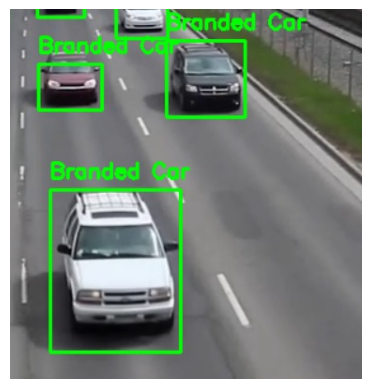

the number of brande cars in video:3


In [ ]:
import cv2


video_path = r"C:\Users\saich\Downloads\task_6_video.mp4"  # Replace with your video path
cap = cv2.VideoCapture(video_path)

# Check if video loaded successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()


background_subtractor = cv2.createBackgroundSubtractorMOG2()

# Parameters
branded_car_count = 0  # To count moving objects (cars)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    fg_mask = background_subtractor.apply(gray_frame)
    _, fg_mask = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)
    fg_mask = cv2.dilate(fg_mask, None, iterations=2)

    # Find contours to identify moving objects (potential cars)
    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) < 500:  # Skip small contours
            continue

    
        x, y, w, h = cv2.boundingRect(contour)
        
        # Count the moving object as a "branded car"
        branded_car_count += 1
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, "Branded Car", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)


    cv2.imshow("Branded Car Detection", frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Output the total count
print(f"Total count of branded car appearances: {branded_car_count}")
